In [9]:
import pandas as pd
import errno    
import os
import numpy as np
import math
import pickle
import time

'''
Author: Enrico Ceccolini
    Correspond to an offline power prediction model to be used to predict the mean 
    power consumption, over the execution interval, of a job submitted on the Erurora HPC. 
'''

datadir = "/datasets/eurora_data/db_local/"
#datadir = "/datasets/eurora_data/db/" #hdd

infile_jobs_to_nodes = datadir + "job_nodes.csv"

suffix = "_5sec_"
### select an interval from
## 1 settings wholeData
#interval_comment_whole = "WholeData"

### select an interval from


## 2 settings Andrea
interval_comment = "Andrea"
start_time = pd.to_datetime('2014-03-31')
end_time = pd.to_datetime('2014-05-01')
infile_jobs = datadir + "april_long_jobs.csv"

## 3 settings Alina
interval_comment = "Alina"
start_time = pd.to_datetime('2014-03-31')
end_time = pd.to_datetime('2014-11-01')
train_start_time = pd.to_datetime('2014-03-31')
train_end_time = pd.to_datetime('2014-10-01')
test_end_time = pd.to_datetime('2014-11-01')


infile_jobs_trainset = datadir + "CPUs/" + interval_comment + "/" + interval_comment + "_trainset"
infile_jobs_testset = datadir + "CPUs/" + interval_comment + "/" + interval_comment + "_testset"
infile_user_job_node = datadir + "CPUs/" + interval_comment + "/" + interval_comment + "_mean_core_user_job_node_whole_clear"

#infile_jobs_trainset = datadir + "CPUs/" + interval_comment + "/" + interval_comment + "_trainset_clear"
#infile_jobs_testset = datadir + "CPUs/" + interval_comment + "/" + interval_comment + "_testset_clear"
#infile_user_job_node = datadir + "CPUs/" + interval_comment + "/" + interval_comment + "_mean_core_user_job_node_whole_clear"

#outfile_testset_pred = datadir + "CPUs/" + interval_comment + "/" + interval_comment + "_testset_pred"
#
#infile_jobs_trainset = datadir + "CPUs/" + interval_comment + "/" + interval_comment + "_trainset_random"
#infile_jobs_testset = datadir + "CPUs/" + interval_comment + "/" + interval_comment + "_testset_random"
#outfile_user_job_node = datadir + "CPUs/" + interval_comment + "/" + interval_comment + "_mean_core_user_job_node_whole_random"
#infile_user_job_node = datadir + "CPUs/" + interval_comment + "/" + interval_comment + "_mean_core_user_job_node_whole_random"
#outfile_user_job_node_dict = datadir + "CPUs/" + interval_comment + "/" + interval_comment + "_mean_core_user_job_node_whole_random"


nodes=['01', '02', '03', '04', '05', '06', '07', '08', '09', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', '27', '28', '29', '30', '31', '32', '33', '34', '35', '36', '37', '38', '39', '40', '41', '42', '44', '45', '46', '47', '48', '49', '50', '51', '52', '53', '54', '55', '56', '57', '58', '59', '60', '61', '62', '63', '64']

In [2]:
jobs_train = pd.read_csv(infile_jobs_trainset + ".csv", index_col=0)
print("train set contains {} records".format(jobs_train.shape[0]))
jobs_test = pd.read_csv(infile_jobs_testset + ".csv", index_col=0)
print("test set contains {} records".format(jobs_test.shape[0]))

train set contains 286096 records
test set contains 23987 records


In [3]:
jobs_to_nodes_whole_data = pd.read_csv(infile_jobs_to_nodes, index_col=0)
print("jobs_to_nodes_whole_data contains {} records".format(jobs_to_nodes_whole_data.shape[0]))
### clean the data
# remove jobs runned on the inexistent node 129
jobs_to_nodes_whole_data = jobs_to_nodes_whole_data[jobs_to_nodes_whole_data['node_id'] != 129] 
# remove jobs with the same id that runned on the same node
jobs_to_nodes_whole_data = jobs_to_nodes_whole_data.drop_duplicates(subset=['job_id_string', 'node_id'])
print("after the clean, jobs_to_nodes_whole_data contains {} records".format(jobs_to_nodes_whole_data.shape[0]))

jobs_to_nodes_whole_data contains 469095 records
after the clean, jobs_to_nodes_whole_data contains 444610 records


In [4]:
jobs_to_nodes_whole_data[jobs_to_nodes_whole_data['job_id_string'] == '502893.node129']

,node_id,job_id_string,ncpus,ngpus,nmics,mem_requested
job2node_id,,,,,,
3114,7,502893.node129,2,0,0,3145728
3116,8,502893.node129,2,0,0,3145728
3121,9,502893.node129,2,0,0,3145728


In [5]:
### merge the info from the two tables
merged_jobs_to_nodes = pd.merge(jobs_test, jobs_to_nodes_whole_data, how='left', on='job_id_string')
print("merged_jobs_to_nodes contains {} records".format(merged_jobs_to_nodes.shape[0]))

# before 18751

merged_jobs_to_nodes contains 24638 records


In [6]:
grouped_jobs_test = merged_jobs_to_nodes.groupby(['user', 'job_name', 'node_id']).size().reset_index(name='counts')

print("{}/{} distinct execution".format(grouped_jobs_test.shape[0], merged_jobs_to_nodes.shape[0]))

21359/24638 distinct execution


In [7]:
grouped_jobs_test = jobs_test.groupby(['user', 'job_name']).size().reset_index(name='counts')
print("{}/{} distinct job names".format(grouped_jobs_test.shape[0], merged_jobs_to_nodes.shape[0]))

7688/24638 distinct job names


In [10]:
# ---- whole dictionary

with open(infile_user_job_node + ".pkl", 'rb') as handle:
    dict_user_job_node = pickle.load(handle)

In [11]:
d_nodes = dict_user_job_node['node_avg']

In [12]:
d_nodes

{1: [9.412870890519518, 1514, nan],
 2: [8.09391791851139, 238, nan],
 3: [13.929631765797023, 1074, nan],
 4: [14.081286050897335, 1236, nan],
 5: [17.82518991790116, 474, nan],
 6: [14.080983170049532, 1107, nan],
 7: [13.585417599201389, 1173, nan],
 8: [14.290726999949381, 1051, nan],
 9: [13.33043611634258, 694, nan],
 10: [13.379478566001326, 1056, nan],
 11: [12.897646442632544, 1187, nan],
 12: [14.486599656597889, 409, nan],
 13: [12.49010278483106, 1102, nan],
 14: [16.13195849821204, 367, nan],
 15: [14.4973800983381, 371, nan],
 16: [13.590925932585263, 384, nan],
 17: [28.519398627422056, 1183, nan],
 18: [12.580770078352447, 807, nan],
 19: [12.556825897245975, 854, nan],
 20: [12.28538411092522, 997, nan],
 21: [12.654484912238066, 976, nan],
 22: [13.035558152376188, 3, nan],
 23: [12.928041842556137, 920, nan],
 24: [12.585200228793166, 1061, nan],
 25: [12.331907793145398, 997, nan],
 26: [12.592816775317939, 727, nan],
 27: [12.837390637877455, 1016, nan],
 28: [12.6

In [14]:
dict_user_job_node_copy = dict(dict_user_job_node)

In [15]:
#dict_user_job_node

In [16]:
def validate_predictions_2(y_values, predictions):
    mean_real_pow = y_values.mean()
    #print("the mean is {}".format(mean_real_pow))

    eq_num = (y_values - predictions)**2
    eq_den = (y_values - mean_real_pow)**2
    N = eq_num.shape[0]

    r_2 = 1 - (eq_num.sum() / eq_den.sum())
    print("r_2 is {}".format(r_2))

    rmse = math.sqrt(eq_num.sum() / N)
    #print("RMSE is {}".format(rmse))
    print("NRMSE is {}".format(rmse/mean_real_pow))
    
    prediction_error = np.abs(predictions - y_values) / predictions
    clean_prediction = prediction_error[~np.isnan(prediction_error)]
    print("prediction error is {}".format(np.average(clean_prediction)))
    print("{}/{}".format(clean_prediction.shape[0], prediction_error.shape[0]))
    
    return r_2
    

In [17]:
''' 1 dictionary
Predict the power consumption of a job.
    If the user and the job name are known, than it use the method 1 [user,job,nodes]
    if only the user is known, than it use the method 2 [user,nodes]
    Otherwise it use the method 3 [nodes]
'''

def predict_pow_treshold_dict(user, job_name, used_nodes, used_cpus, treshold_5=1, treshold_4=1, treshold_3=0, treshold_2=0):
    pred_pow = 0.0
    
    methods = [0, 0, 0, 0, 0]  
    
    d_nodes = dict_user_job_node['node_avg']
    
    if(user in dict_user_job_node):
        d_user = dict_user_job_node[user]
        
        if(job_name in d_user):
            d_user_job = d_user[job_name]
            for node_id, ncpu in zip(used_nodes, used_cpus):
                if(node_id in d_user_job and d_user_job[node_id][1] > treshold_5): # method 5 - user - job - node
                    pred_pow += d_user_job[node_id][0] * ncpu
                    methods[0] += 1
                elif(d_user_job['user_job_avg'][1] > treshold_4): #  method 4 - user - job
                    pred_pow += d_user_job['user_job_avg'][0] * ncpu
                    methods[1] += 1
                elif(node_id in d_user['user_node_avg'] and d_user['user_node_avg'][node_id][1] > treshold_3): # method 3 - user - node
                    pred_pow += d_user['user_node_avg'][node_id][0] * ncpu
                    methods[2] += 1
                elif(d_user['user_avg'][1] > treshold_2): # method 2 - user
                    pred_pow += d_user['user_avg'][0] * ncpu
                    methods[3] += 1
                else: # method 1 - node
                    pred_pow += d_nodes[node_id][0] * ncpu
                    methods[4] += 1
                    
        else: # NON ho il job         
            for node_id, ncpu in zip(used_nodes, used_cpus):
                if(node_id in d_user['user_node_avg'] and d_user['user_node_avg'][node_id][1] > treshold_3): # method 3 - user - node
                    pred_pow += d_user['user_node_avg'][node_id][0] * ncpu
                    methods[2] += 1
                elif(d_user['user_avg'][1] > treshold_2): # method 2 - user
                    pred_pow += d_user['user_avg'][0] * ncpu
                    methods[3] += 1
                else: # method 1 - node
                    pred_pow += d_nodes[node_id][0] * ncpu
                    methods[4] += 1

    else:  # method 1 - node
        #d_nodes = dict_user_job_node['node_avg']
        for node_id, ncpu in zip(used_nodes, used_cpus):
            pred_pow += d_nodes[node_id][0] * ncpu
            methods[4] += 1
    
    return (methods, pred_pow)

In [18]:
import matplotlib.pyplot as plt

def my_scatter_plot(x_values, y_values, xy_min, xy_lim, mark_s=100, title=""):

    #fig, = plt.figure(figsize=(9, 9))  
    
    fig, ax = plt.subplots(figsize=(20, 8))
    
    x1 = [0, xy_lim]
    y1 = [0, xy_lim]
    ax.plot(x1, y1, 'gray', linestyle=':', marker='')
    
    plt.xlabel('real pow (w)', fontsize=18)
    plt.ylabel('predicted pow (w)', fontsize=18)
    plt.title(title, fontsize=20)
    
    ax.tick_params(axis='x', labelsize=15)
    ax.tick_params(axis='y', labelsize=15)

    plt.xlim(xy_min, xy_lim)
    plt.ylim(xy_min, xy_lim)
    #plt.gca().set_aspect('equal', adjustable='box')
    
    #visualize results
    plt.scatter(x_values, y_values, marker='x', s=mark_s)
    plt.plot()

    plt.show()

In [19]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime
from matplotlib.pyplot import figure
#plt.rcParams['figure.figsize'] = (15,8)

def plotPredError(differences, nbins=1000, min_x=-1000, max_x=1000, max_y=6000):

    fig, ax = plt.subplots(figsize=(15, 8))
    #num_bins = 3000
    n, bins, patches = plt.hist(differences, bins = nbins, facecolor='blue', alpha=1)
    #plt.axis([-0.25, 0.25, 0, 3000])
    plt.axis([min_x, max_x, 0, max_y])
    plt.xlabel("prediction error (w)", fontsize=18)
    plt.ylabel("data points", fontsize=18)

    ax.tick_params(axis='x', labelsize=15)
    ax.tick_params(axis='y', labelsize=15)

    plt.show()

In [20]:
import matplotlib.pyplot as plt

def my_scatter_plot_small(x_values, y_values, xy_min, xy_lim, mark_s=100, title=""):

    #fig, = plt.figure(figsize=(9, 9))  
    
    fig, ax = plt.subplots(figsize=(15, 8))
    
    x1 = [0, xy_lim]
    y1 = [0, xy_lim]
    ax.plot(x1, y1, 'gray', linestyle=':', marker='')
    
    plt.xlabel('real pow (w)', fontsize=18)
    plt.ylabel('predicted pow (w)', fontsize=18)
    plt.title(title, fontsize=20)
    
    ax.tick_params(axis='x', labelsize=15)
    ax.tick_params(axis='y', labelsize=15)

    plt.xlim(xy_min, xy_lim)
    plt.ylim(xy_min, xy_lim)
    #plt.gca().set_aspect('equal', adjustable='box')
    
    #visualize results
    plt.scatter(x_values, y_values, marker='x', s=mark_s)
    plt.plot()

    plt.show()

In [21]:
jobs_test.columns

Index(['job_id_string', 'job_name', 'queue', 'start_time', 'run_start_time',
       'end_time', 'user', 'node_req', 'cpu_req', 'mem_req', 'time_req',
       'deleted', 'dependency', 'exit_status', 'pbs_exit_code', 'gpu_req',
       'mic_req', 'real_pow', 'ran_alone', 'real_pow_quality', 'n_2_1',
       'n_2_2', 'n_3_1', 'job_tot_timepoints', 'job_timepoints', 'good_nodes',
       'real_pow_acc'],
      dtype='object')

In [22]:
df_jobs_to_test = jobs_test

In [23]:
start_time = time.time()

# select jobs to test and create the list
# set as job_test if you want to make a complete test on the test_set

#df_jobs_to_test = jobs_test.head(1000)

#df_jobs_to_test = jobs_test # test on whole testset
list_jobs_to_test = []

for index_job_test, row_job_test in df_jobs_to_test.iterrows():
    
    merged_job_to_nodes = merged_jobs_to_nodes[merged_jobs_to_nodes['job_id_string'] == row_job_test['job_id_string']]
    grouped_job_to_nodes = merged_job_to_nodes.groupby(['node_id', 'ncpus','ngpus', 'nmics']).size().reset_index(name='counts')
    
    used_nodes = grouped_job_to_nodes['node_id'].tolist()
    used_cpus = grouped_job_to_nodes['ncpus'].tolist()
    
    list_jobs_to_test.append([row_job_test['user'], row_job_test['job_name'], used_nodes, used_cpus, row_job_test['real_pow']])
    

list_jobs_to_test_bk = list_jobs_to_test
print("--- %s seconds ---" % (time.time() - start_time))

--- 281.8209161758423 seconds ---


In [25]:
#jobs_test

### compare 5 methods

In [33]:
with open(infile_user_job_node + ".pkl", 'rb') as handle:
    dict_user_job_node = pickle.load(handle)
jobs_predictions = []
global_methods_online = [0, 0, 0, 0, 0]

for job in list_jobs_to_test:
    methods, predicted_pow = predict_pow_treshold_dict(user=job[0], job_name=job[1], used_nodes=job[2],
        used_cpus=job[3], treshold_5=0, treshold_4=0, treshold_3=0, treshold_2=0)
        #used_cpus=job[3], treshold_5=4, treshold_4=4, treshold_3=4, treshold_2=4)
    
    if True:
        for j in range(5):
            global_methods_online[j] += methods[j]
    
    jobs_predictions.append(predicted_pow)
    
print(global_methods_online)
# print(sum(global_methods_online))

validate_predictions_2(df_jobs_to_test['real_pow'], jobs_predictions)

# before
#[1487, 4115, 18717, 282, 37]
#r_2 is 0.8082293315967952
#NRMSE is 1.0629798497671132
#prediction error is 0.5839403176615995
#23987/23987

#0.8082293315967952


[3712, 5434, 15370, 97, 25]
r_2 is 0.8346643590787302
NRMSE is 1.0000564492328512
prediction error is 0.6882158451111019
23987/23987


0.8346643590787302

In [34]:
df_jobs_to_test[df_jobs_to_test['real_pow']<1].shape

(130, 27)

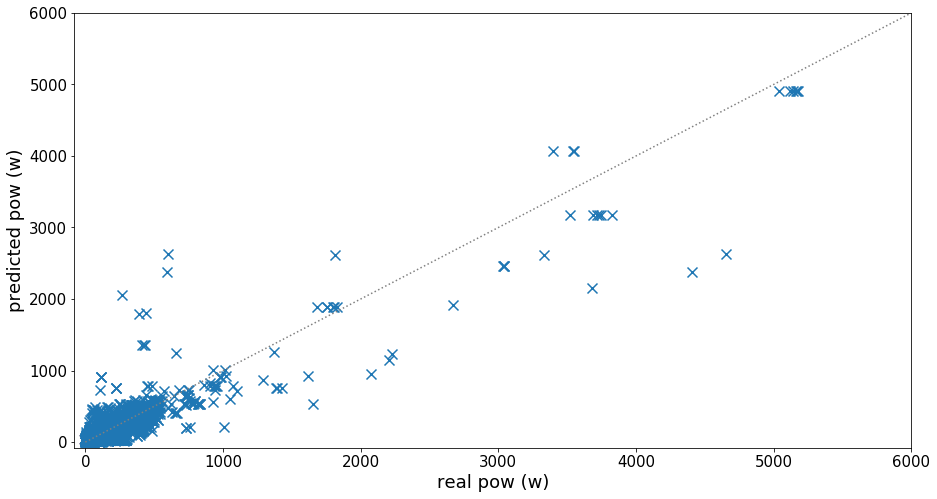

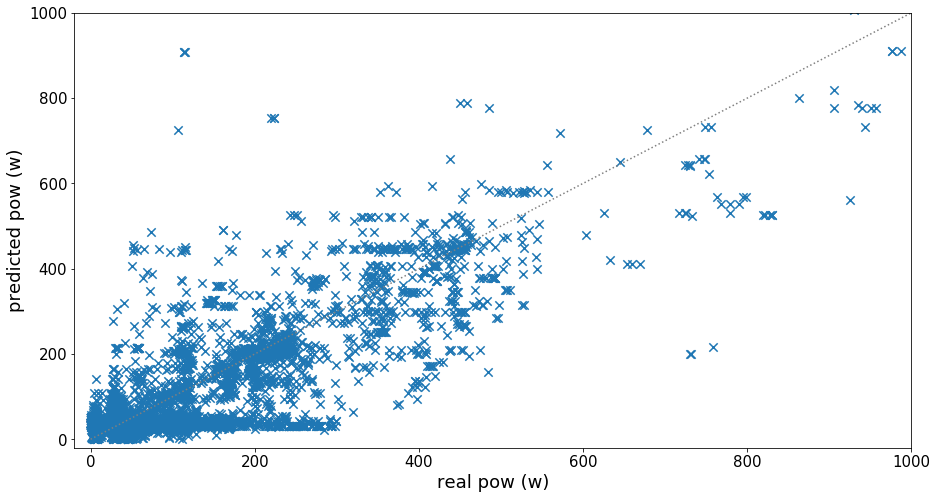

In [35]:
#job_to_test = jobs_test[jobs_test['pred_perNode'] != -1] # some users are unknown
my_scatter_plot_small(title="", x_values=df_jobs_to_test['real_pow'], y_values=jobs_predictions, xy_min=-80, xy_lim=6000)
my_scatter_plot_small(title="", x_values=df_jobs_to_test['real_pow'], y_values=jobs_predictions, xy_min=-20, xy_lim=1000, mark_s=70)

r_2 is 0.8346643590787302
NRMSE is 1.0000564492328512
prediction error is 0.6882158451111019
23987/23987


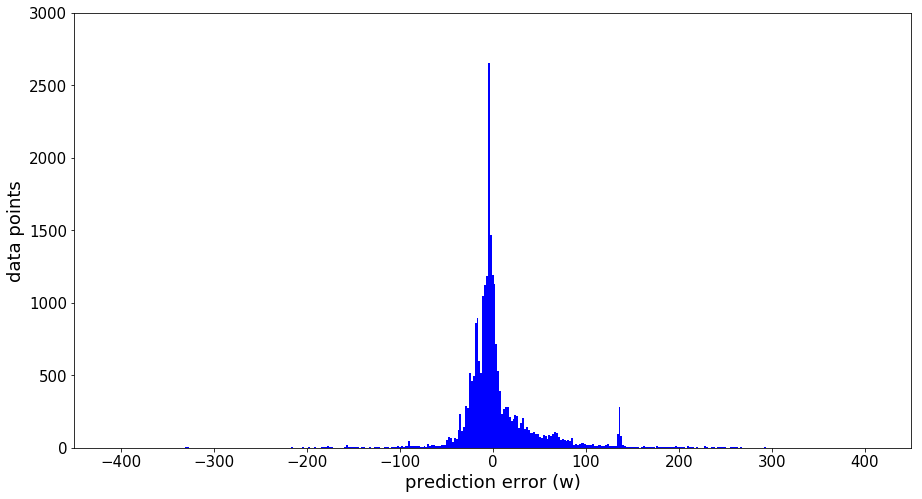

In [36]:
validate_predictions_2(df_jobs_to_test['real_pow'], jobs_predictions)

differences = df_jobs_to_test['real_pow'] - jobs_predictions
#df = pd.DataFrame(differences)
#df = df.apply(lambda x: (x - np.mean(x)) / (np.max(x) - np.min(x)))
#differences_norm = df['real_pow']
plotPredError(differences, nbins=2000, min_x=-450, max_x=450, max_y=3000)

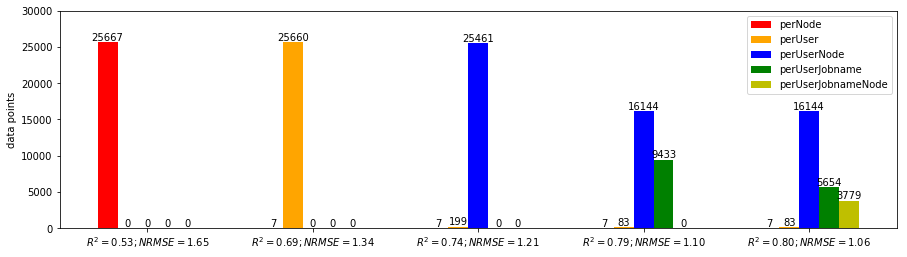

In [37]:
x = [[],
     [],
     [],
     [],
     []]

"""
========
Barchart
========

A bar plot with errorbars and height labels on individual bars
"""
import numpy as np
import matplotlib.pyplot as plt

N = 5
#offline
m1 = (0, 0, 0, 0, 3779)
m2 = (0, 0, 0, 9433, 5654)
m3 = (0, 0, 25461, 16144, 16144)
m4 = (0, 25660, 199, 83, 83)
m5 = (25667, 7, 7, 7, 7)


ind = np.arange(N)  # the x locations for the groups
width = 0.12      # the width of the bars

fig, ax = plt.subplots(figsize=(15, 4))
rects1 = ax.bar(ind, m5, width, color='r')
rects2 = ax.bar(ind+width, m4, width, color='orange')
rects3 = ax.bar(ind+width*2, m3, width, color='b')
rects4 = ax.bar(ind+width*3, m2, width, color='g')
rects5 = ax.bar(ind+width*4, m1, width, color='y')

# add some text for labels, title and axes ticks
ax.set_ylabel('data points')
ax.set_title('')
ax.set_xticks(ind + 2*width)
#ax.set_xticklabels(('$R^2=0.44; NRMSE=1.60$', '$R^2=0.59; NRMSE=1.37$', '$R^2=0.64; NRMSE=1.28$', '$R^2=0.68; NRMSE=1.20$', '$R^2=0.69; NRMSE=1.18$'))
ax.set_xticklabels(('$R^2=0.53; NRMSE=1.65$', '$R^2=0.69; NRMSE=1.34$', '$R^2=0.74; NRMSE=1.21$', '$R^2=0.79; NRMSE=1.10$', '$R^2=0.80; NRMSE=1.06$'))
axes = plt.gca()
#axes.set_xlim([xmin,xmax])
axes.set_ylim([0,30000])

ax.legend((rects1[0], rects2[0], rects3[0], rects4[0], rects5[0]), 
('perNode', 'perUser', 'perUserNode', 'perUserJobname', 'perUserJobnameNode'))


def autolabel(rects):
    """
    Attach a text label above each bar displaying its height
    """
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., height,
                '%d' % int(height),
                ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)
autolabel(rects3)
autolabel(rects4)
autolabel(rects5)

plt.show()

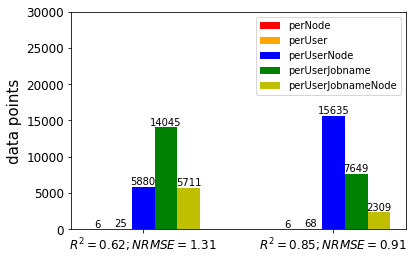

In [38]:
import numpy as np
import matplotlib.pyplot as plt

N = 2
#online
m1 = (5711, 2309)
m2 = (14045, 7649)
m3 = (5880, 15635)
m4 = (25, 68)
m5 = (6, 6)


ind = np.arange(N)  # the x locations for the groups
width = 0.12      # the width of the bars

fig, ax = plt.subplots(figsize=(6, 4))
rects1 = ax.bar(ind, m5, width, color='r')
rects2 = ax.bar(ind+width, m4, width, color='orange')
rects3 = ax.bar(ind+width*2, m3, width, color='b')
rects4 = ax.bar(ind+width*3, m2, width, color='g')
rects5 = ax.bar(ind+width*4, m1, width, color='y')

# add some text for labels, title and axes ticks
ax.set_ylabel('data points')
ax.set_title('')
ax.set_xticks(ind + 2*width)
ax.set_xticklabels(('$R^2=0.62; NRMSE=1.31$', '$R^2=0.85; NRMSE=0.91$'))
axes = plt.gca()
#axes.set_xlim([xmin,xmax])
axes.set_ylim([0,30000])

plt.ylabel('data points', fontsize=15)

ax.tick_params(axis='x', labelsize=12)
ax.tick_params(axis='y', labelsize=12)

ax.legend((rects1[0], rects2[0], rects3[0], rects4[0], rects5[0]), 
('perNode', 'perUser', 'perUserNode', 'perUserJobname', 'perUserJobnameNode'))


def autolabel(rects):
    """
    Attach a text label above each bar displaying its height
    """
    for rect in rects:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width()/2., height,
                '%d' % int(height),
                ha='center', va='bottom')

autolabel(rects1)
autolabel(rects2)
autolabel(rects3)
autolabel(rects4)
autolabel(rects5)

plt.show()

#r_2 is 0.855607833633744
#NRMSE is 0.8173757541715595

### Offline

In [39]:
# predict offline misuring the time

# ---- whole dictionary
#infile_user_job_node = datadir + "CPUs/" + interval_comment + "/" + interval_comment + "_mean_core_user_job_node_whole"
#infile_user_job_node = datadir + "CPUs/" + interval_comment + "/" + interval_comment + "_mean_core_user_job_node_whole_clear"
#
#with open(infile_user_job_node + ".pkl", 'rb') as handle:
#    dict_user_job_node = pickle.load(handle)
with open(infile_user_job_node + ".pkl", 'rb') as handle:
    dict_user_job_node = pickle.load(handle)
jobs_predictions = []
global_methods_online = [0, 0, 0, 0, 0]

start_time = time.time()

for job in list_jobs_to_test:
    #methods, predicted_pow = predict_pow_treshold_dict(user=job[0], job_name=job[1], used_nodes=job[2],
    #    used_cpus=job[3], treshold_5=1, treshold_4=5, treshold_3=1, treshold_2=12)
    #methods, predicted_pow = predict_pow_treshold_dict(user=job[0], job_name=job[1], used_nodes=job[2],
     #   used_cpus=job[3], treshold_5=4, treshold_4=6, treshold_3=2, treshold_2=8)
    methods, predicted_pow = predict_pow_treshold_dict(user=job[0], job_name=job[1], used_nodes=job[2],
        used_cpus=job[3], treshold_5=4, treshold_4=4, treshold_3=4, treshold_2=0)
    
    if True:
        for j in range(5):
            global_methods_online[j] += methods[j]
    
    jobs_predictions.append(predicted_pow)
    
print("--- %s seconds ---" % (time.time() - start_time))
print(global_methods_online)
print(sum(global_methods_online))

#print(df_jobs_to_test['real_pow'])
#print([(lambda x: print(x))(x) for x in jobs_predictions])
validate_predictions_2(df_jobs_to_test['real_pow'], jobs_predictions)

#--- 0.08289122581481934 seconds ---
#[0, 0, 0, 0, 0]
#0
#r_2 is 0.7666871168925228
#NRMSE is 1.1430627928001074
#
#0.7666871168925228

--- 0.14387059211730957 seconds ---
[1423, 4102, 18720, 368, 25]
24638
r_2 is 0.8343205581506778
NRMSE is 1.0010956739970605
prediction error is 0.5807616011501242
23987/23987


0.8343205581506778

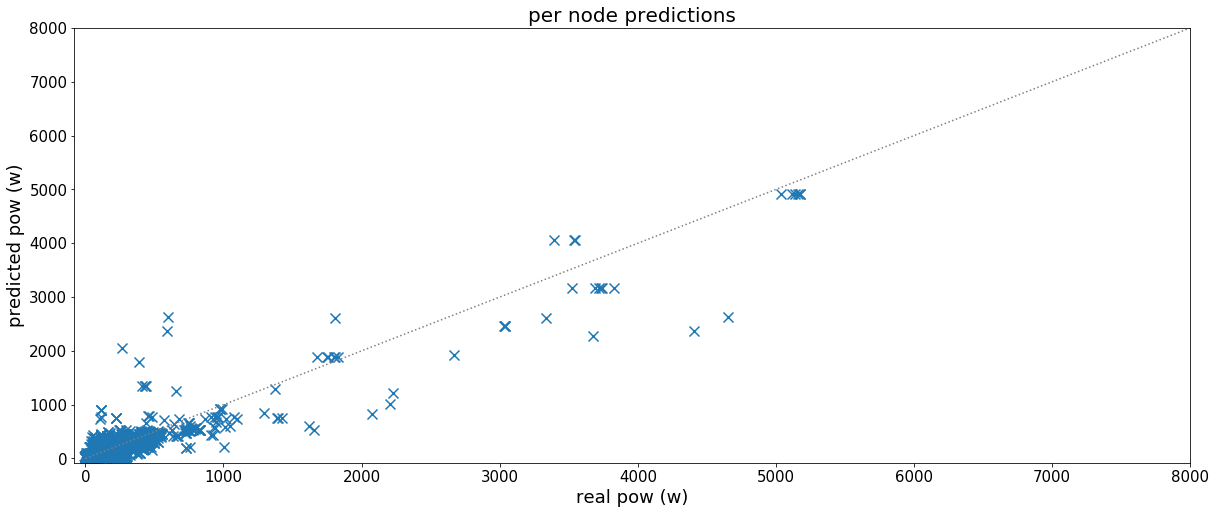

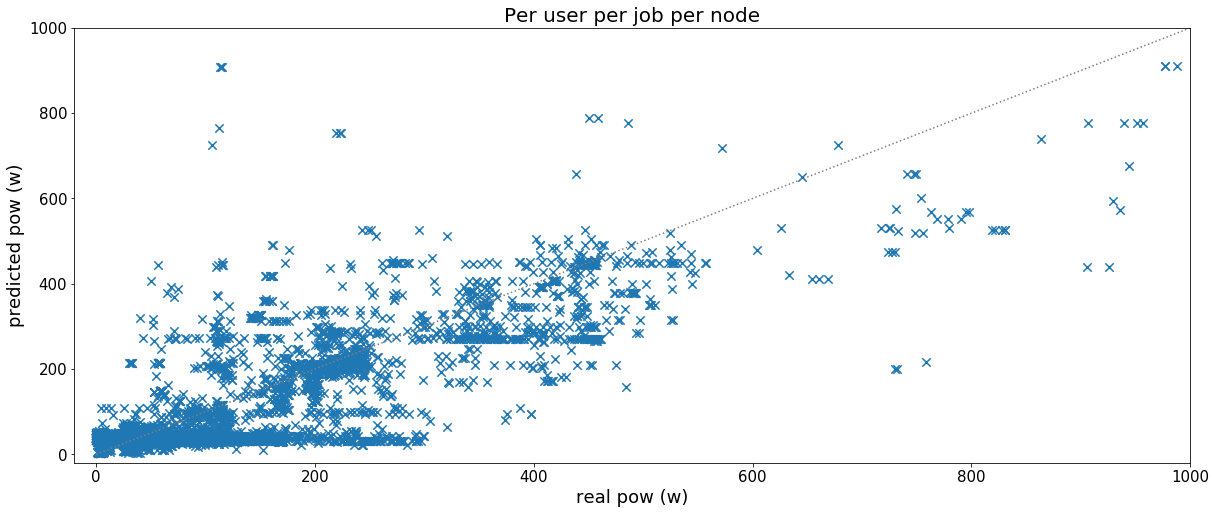

In [40]:
#job_to_test = jobs_test[jobs_test['pred_perNode'] != -1] # some users are unknown
my_scatter_plot(title="per node predictions", x_values=df_jobs_to_test['real_pow'], y_values=jobs_predictions, xy_min=-80, xy_lim=8000)
my_scatter_plot(title="Per user per job per node", x_values=df_jobs_to_test['real_pow'], y_values=jobs_predictions, xy_min=-20, xy_lim=1000, mark_s=70)

In [41]:
jobs_test['pred_offline_threshold'] = jobs_predictions
jobs_test.to_csv(infile_jobs_testset + ".csv")

In [42]:
''' 1 dictionary
Predict the power consumption of a job.
    If the user and the job name are known, than it use the method 1 [user,job,nodes]
    if only the user is known, than it use the method 2 [user,nodes]
    Otherwise it use the method 3 [nodes]
'''

def update_dict(user, job_name, used_nodes, mean_core_cons):
    
    #updaterM1 = 1
    #updaterM2 = 5
    #updaterM3 = 100
    #updaterM4 = 10
    #updaterM5 = 10
    
    #updaterM1 = 1
    #updaterM2 = 1
    ##updaterM3 = 10
    #updaterM4 = 10
    #updaterM5 = 10
    mult_perc = 0.1
    
    if(user not in dict_user_job_node): # uknown user
        dict_user_job_node[user] = {}
        dict_user_job_node[user]['user_avg'] = [0, 0]
        dict_user_job_node[user]['user_node_avg'] = {}
        
        dict_user_job_node[user][job_name] = {}
        dict_user_job_node[user][job_name]['user_job_avg'] = [0, 0] 
        
    elif(job_name not in dict_user_job_node[user]): # unknown job
        dict_user_job_node[user][job_name] = {}
        dict_user_job_node[user][job_name]['user_job_avg'] = [0, 0] 
    
    for node_id in used_nodes:
        
        # 5. per user-job-node
        if(node_id in dict_user_job_node[user][job_name]): # known node
            prev_values = dict_user_job_node[user][job_name][node_id]
            updaterM5 = prev_values[1]*mult_perc + 1
            dict_user_job_node[user][job_name][node_id][0] = (prev_values[0] * prev_values[1] + mean_core_cons*updaterM5) / (prev_values[1] + updaterM5)
            dict_user_job_node[user][job_name][node_id][1] = prev_values[1] + 1
        else:
            dict_user_job_node[user][job_name][node_id] = [mean_core_cons, 1] 
           
        # 3. per user-node
        if(node_id in dict_user_job_node[user]['user_node_avg']): # known node
            prev_values = dict_user_job_node[user]['user_node_avg'][node_id]
            updaterM3 = prev_values[1]*mult_perc + 1
            dict_user_job_node[user]['user_node_avg'][node_id][0] = (prev_values[0] * prev_values[1] + mean_core_cons*updaterM3) / (prev_values[1] + updaterM3)
            dict_user_job_node[user]['user_node_avg'][node_id][1] = prev_values[1] + 1
        else:
            dict_user_job_node[user]['user_node_avg'][node_id] = [mean_core_cons, 1] 
            
        # 1. per node
        prev_values = dict_user_job_node['node_avg'][node_id]
        updaterM1 = prev_values[1]*mult_perc + 1
        dict_user_job_node['node_avg'][node_id][0] = (prev_values[0] * prev_values[1] + mean_core_cons*updaterM1) / (prev_values[1] + updaterM1)
        dict_user_job_node['node_avg'][node_id][1] = prev_values[1] + 1
        
    # 4. per user-job
    prev_values = dict_user_job_node[user][job_name]['user_job_avg']
    updaterM4 = prev_values[1]*mult_perc + 1
    dict_user_job_node[user][job_name]['user_job_avg'][0] = (prev_values[0] * prev_values[1] + mean_core_cons*updaterM4) / (prev_values[1] + updaterM4)
    dict_user_job_node[user][job_name]['user_job_avg'][1] = prev_values[1] + 1
    
    # 2. per user
    prev_values = dict_user_job_node[user]['user_avg']
    updaterM2 = prev_values[1]*mult_perc + 1
    dict_user_job_node[user]['user_avg'][0] = (prev_values[0] * prev_values[1] + mean_core_cons*updaterM2) / (prev_values[1] + updaterM2)
    dict_user_job_node[user]['user_avg'][1] = prev_values[1] + 1

In [43]:
# predict online misuring the time

# ---- whole dictionary
#infile_user_job_node = datadir + "CPUs/" + interval_comment + "/" + interval_comment + "_mean_core_user_job_node_whole"
#infile_user_job_node = datadir + "CPUs/" + interval_comment + "/" + interval_comment + "_mean_core_user_job_node_whole_clear"

with open(infile_user_job_node + ".pkl", 'rb') as handle:
    dict_user_job_node = pickle.load(handle)


#dict_user_job_node = dict(dict_user_job_node_copy)
jobs_predictions = []
global_methods_online = [0, 0, 0, 0, 0]

start_time = time.time()

for job in list_jobs_to_test:
    methods, predicted_pow = predict_pow_treshold_dict(user=job[0], job_name=job[1], used_nodes=job[2],
        #used_cpus=job[3], treshold_5=0, treshold_4=0, treshold_3=0, treshold_2=0)
        used_cpus=job[3], treshold_5=4, treshold_4=4, treshold_3=4, treshold_2=4)
    #print(job)
    mean_core_cons = job[4] / sum(job[3])
    update_dict(user=job[0], job_name=job[1], used_nodes=job[2], mean_core_cons=mean_core_cons)
    
    if True:
        for j in range(5):
            global_methods_online[j] += methods[j]
    
    jobs_predictions.append(predicted_pow)
    
print("--- %s seconds ---" % (time.time() - start_time))
print(global_methods_online)
print(sum(global_methods_online))

validate_predictions_2(df_jobs_to_test['real_pow'], jobs_predictions)

#--- 1.7491860389709473 seconds ---
#[1725, 4470, 18315, 109, 19]
#24638
#r_2 is 0.8566888667165693
#NRMSE is 0.9189119644017009
#prediction error is 0.2380632857975301
#23987/23987


--- 1.201141357421875 seconds ---
[1663, 4465, 18324, 130, 56]
24638
r_2 is 0.8732361554215228
NRMSE is 0.8756669819129496
prediction error is 0.22469838981449292
23987/23987


0.8732361554215228

In [44]:
df_jobs_to_test['pred_heur_online'] = jobs_predictions
df_jobs_to_test

,job_id_string,job_name,queue,start_time,run_start_time,end_time,user,node_req,cpu_req,mem_req,...,real_pow_quality,n_2_1,n_2_2,n_3_1,job_tot_timepoints,job_timepoints,good_nodes,real_pow_acc,pred_offline_threshold,pred_heur_online
job_id,,,,,,,,,,,,,,,,,,,,,
308163,1309317.node129,e1nubt_70.csh,parallel,2014-09-30 11:03:27,2014-10-01 07:21:04,2014-10-01 10:46:00,bcatalan@node129.eurora.cineca.it,1,16,1048576,...,0.0,0,0,1,2459,479,1,215.954773,419.145533,419.145533
308442,1309728.node129,a7_wat_epj,parallel,2014-09-30 16:04:21,2014-10-01 06:16:47,2014-10-01 08:14:21,ggrazios@node038.eurora.cineca.it,1,16,14680064,...,0.0,0,0,1,1410,1245,1,132.751503,57.516971,57.516971
309224,1310633.node129,rr72-01-15,parallel,2014-09-30 18:02:32,2014-10-01 04:44:59,2014-10-01 08:45:54,bziosi00@node129.eurora.cineca.it,1,1,1048576,...,0.0,0,0,1,2891,2347,1,50.921275,50.463040,50.463040
309227,1310638.node129,rr72-05-11,parallel,2014-09-30 18:04:25,2014-10-01 04:59:30,2014-10-01 09:01:28,bziosi00@node129.eurora.cineca.it,1,1,1048576,...,0.0,0,0,1,2903,2173,1,86.453991,27.801805,27.801805
309231,1310642.node129,rr72-07-11,parallel,2014-09-30 18:05:22,2014-10-01 05:19:42,2014-10-01 09:19:51,bziosi00@node129.eurora.cineca.it,1,1,1048576,...,0.0,0,0,1,2881,1931,1,57.082423,47.430521,47.430521
309233,1310644.node129,rr72-08-15,parallel,2014-09-30 18:05:44,2014-10-01 05:28:28,2014-10-01 09:29:25,bziosi00@node129.eurora.cineca.it,1,1,1048576,...,0.0,0,0,1,2891,1827,1,87.664058,23.907528,23.907528
309236,1310648.node129,rr73-00-02,parallel,2014-09-30 18:06:50,2014-10-01 06:17:24,2014-10-01 09:59:25,bziosi00@node129.eurora.cineca.it,1,1,1048576,...,0.0,0,0,1,2664,1241,1,81.381918,32.341329,32.341329
309238,1310650.node129,rr73-02-14,parallel,2014-09-30 18:07:21,2014-10-01 06:29:25,2014-10-01 10:29:33,bziosi00@node129.eurora.cineca.it,1,1,1048576,...,0.0,0,0,1,2881,1098,1,84.559046,23.258840,23.258840
309239,1310651.node129,rr73-03-08,parallel,2014-09-30 18:07:36,2014-10-01 06:55:23,2014-10-01 10:56:25,bziosi00@node129.eurora.cineca.it,1,1,1048576,...,0.0,0,0,1,2892,787,1,57.010621,29.619399,29.619399


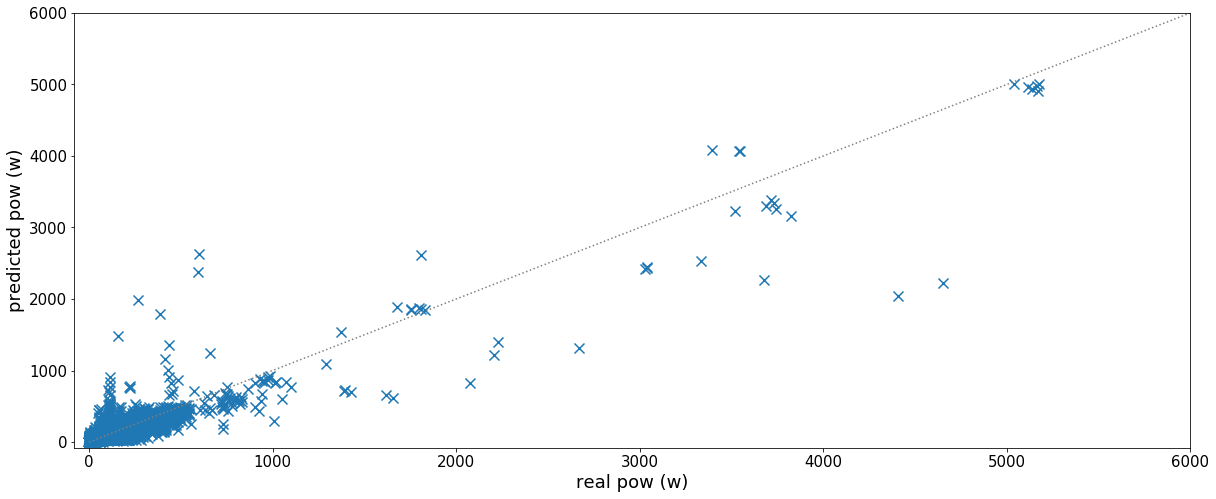

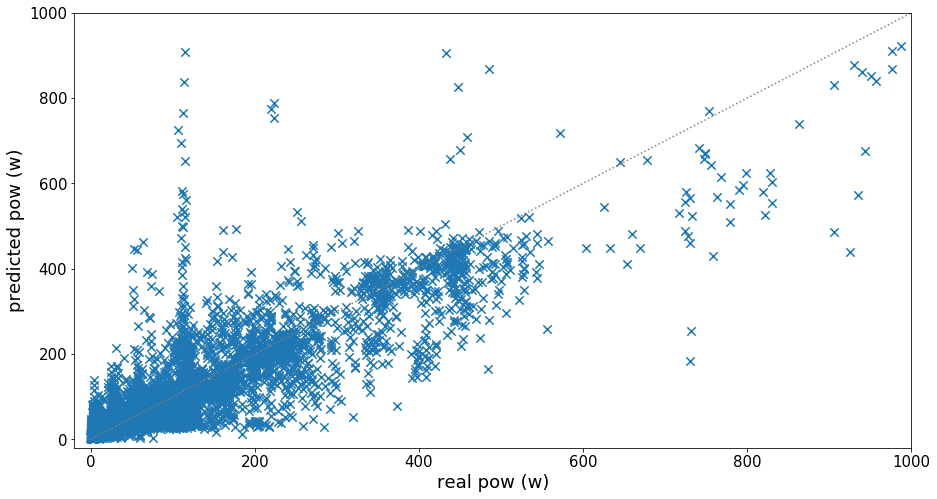

In [45]:
#job_to_test = jobs_test[jobs_test['pred_perNode'] != -1] # some users are unknown 100
my_scatter_plot(title="", x_values=df_jobs_to_test['real_pow'], y_values=jobs_predictions, xy_min=-80, xy_lim=6000)
my_scatter_plot_small(title="", x_values=df_jobs_to_test['real_pow'], y_values=jobs_predictions, xy_min=-20, xy_lim=1000, mark_s=70)

r_2 is 0.8732361554215228
NRMSE is 0.8756669819129496
prediction error is 0.22469838981449292
23987/23987


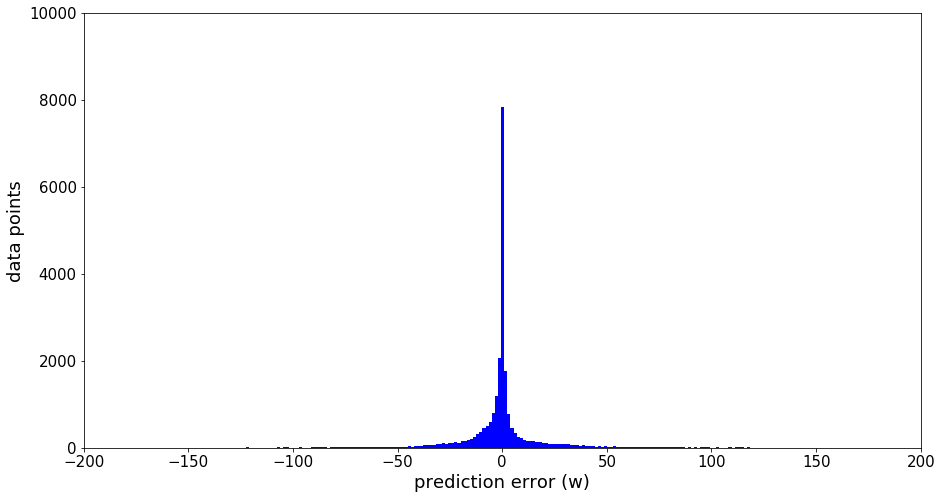

In [46]:
#Alina
#validate_predictions_2(df_jobs_to_test['real_pow'], jobs_predictions)
#differences = df_jobs_to_test['real_pow'] - jobs_predictions
##df = pd.DataFrame(differences)
##df = df.apply(lambda x: (x - np.mean(x)) / (np.max(x) - np.min(x)))
##differences_norm = df['real_pow']
#plotPredError(differences, nbins=6000, min_x=-200, max_x=200, max_y=6000)

#Andrea
validate_predictions_2(df_jobs_to_test['real_pow'], jobs_predictions)
differences = df_jobs_to_test['real_pow'] - jobs_predictions
#df = pd.DataFrame(differences)
#df = df.apply(lambda x: (x - np.mean(x)) / (np.max(x) - np.min(x)))
#differences_norm = df['real_pow']
plotPredError(differences, nbins=3000, min_x=-200, max_x=200, max_y=10000)


r_2 is 0.8732361554215228
NRMSE is 0.8756669819129496
prediction error is 0.22469838981449292
23987/23987


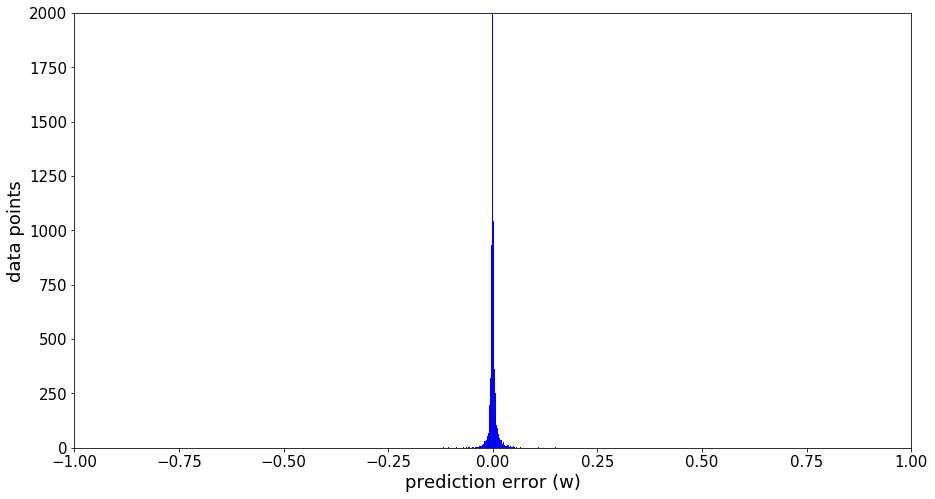

In [47]:
validate_predictions_2(df_jobs_to_test['real_pow'], jobs_predictions)

differences = df_jobs_to_test['real_pow'] - jobs_predictions
df = pd.DataFrame(differences)
df = df.apply(lambda x: (x - np.mean(x)) / (np.max(x) - np.min(x)))
differences_norm = df['real_pow']
plotPredError(differences_norm, nbins=1000, min_x=-1, max_x=1, max_y=2000)


r_2 is 0.8732361554215228
NRMSE is 0.8756669819129496
prediction error is 0.22469838981449292
23987/23987


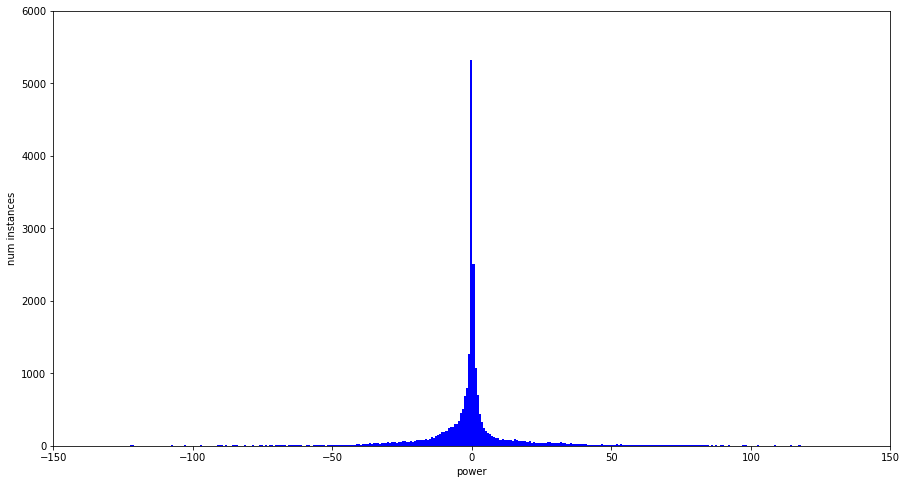

In [48]:
validate_predictions_2(df_jobs_to_test['real_pow'], jobs_predictions)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime
from matplotlib.pyplot import figure
plt.rcParams['figure.figsize'] = (15,8)

differences = df_jobs_to_test['real_pow'] - jobs_predictions
df = pd.DataFrame(differences)
df = df.apply(lambda x: (x - np.mean(x)) / (np.max(x) - np.min(x)))
#differences_norm = df['Total']

num_bins = 6000
n, bins, patches = plt.hist(differences, num_bins, facecolor='blue', alpha=1)
plt.axis([-150, 150, 0, 6000])
plt.xlabel("power")
plt.ylabel("num instances")
plt.show()

r_2 is 0.8732361554215228
NRMSE is 0.8756669819129496
prediction error is 0.22469838981449292
23987/23987


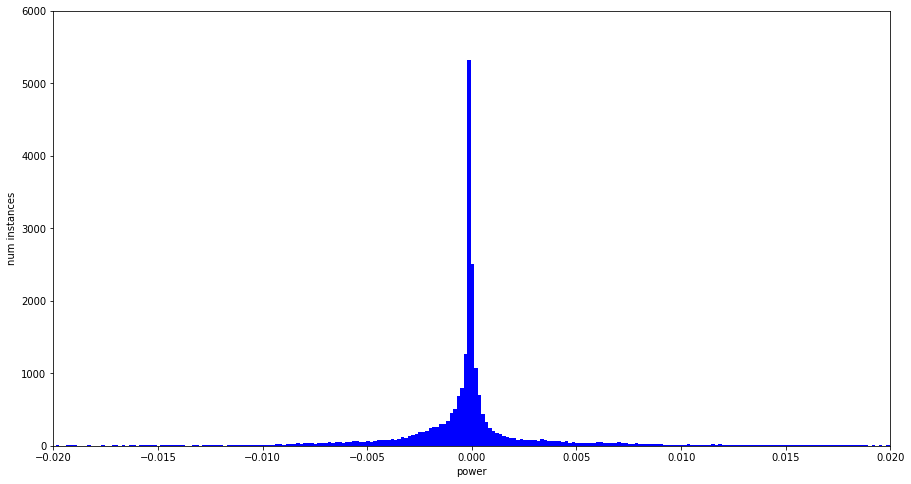

In [49]:
validate_predictions_2(df_jobs_to_test['real_pow'], jobs_predictions)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from datetime import datetime
from matplotlib.pyplot import figure
plt.rcParams['figure.figsize'] = (15,8)

differences = df_jobs_to_test['real_pow'] - jobs_predictions
df = pd.DataFrame(differences)
df = df.apply(lambda x: (x - np.mean(x)) / (np.max(x) - np.min(x)))
differences_norm = df['real_pow']

num_bins = 6000
n, bins, patches = plt.hist(differences_norm, num_bins, facecolor='blue', alpha=1)
plt.axis([-0.02, 0.02, 0, 6000])
plt.xlabel("power")
plt.ylabel("num instances")
plt.show()

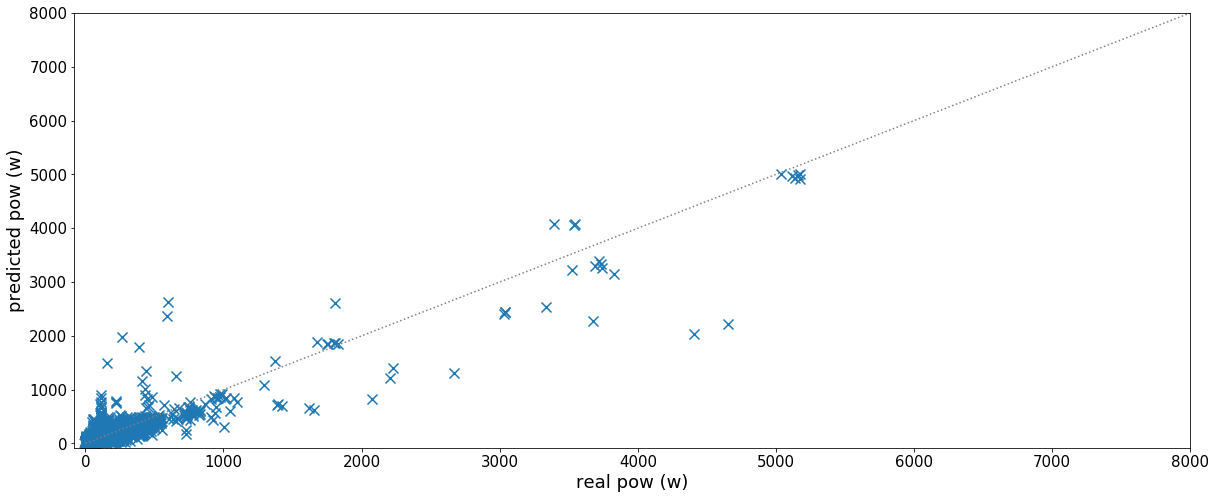

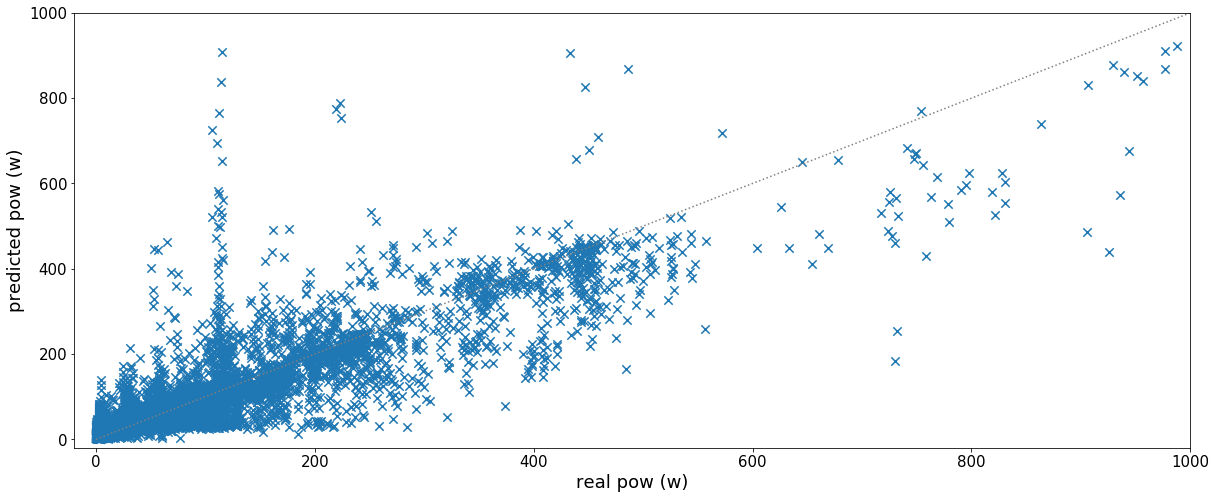

In [50]:
#job_to_test = jobs_test[jobs_test['pred_perNode'] != -1] # some users are unknown 40
my_scatter_plot(title="", x_values=df_jobs_to_test['real_pow'], y_values=jobs_predictions, xy_min=-80, xy_lim=8000)
my_scatter_plot(title="", x_values=df_jobs_to_test['real_pow'], y_values=jobs_predictions, xy_min=-20, xy_lim=1000, mark_s=70)

In [51]:
jobs_test_cp = jobs_test
jobs_test['pred_online_threshold'] = jobs_predictions
jobs_test.to_csv(infile_jobs_testset + ".csv")

In [90]:
jobs_test.groupby(['user', 'job_name']).size().reset_index(name='counts')

,user,job_name,counts
0,a07smr01,A2REPO,6
1,a07smr01,ARKI,8
2,a07smr01,INIT,8
3,a07smr01,LM28_OPE,8
4,a07smr01,LM7_OPE,8
5,a07smr01,LM7_TST,7
6,a07smr01,LM_PRE,10
7,a07smr01,POSTPROCESS,8
8,a07smr01,SWAN_CAM,6
9,a07smr01,SWAN_EMR,6


In [91]:
diff2 = jobs_test.assign(cpu_req=jobs_test.cpu_req.abs()).groupby(['user', 'job_name']).cpu_req.agg([('Min' , 'min'), ('Max', 'max')]).add_prefix('cpu')

In [92]:
diff = jobs_test.assign(real_pow=jobs_test.real_pow.abs()).groupby(['user', 'job_name']).real_pow.agg([('Min' , 'min'), ('Max', 'max')]).add_prefix('real')

In [93]:
diff['cpuMin'] = diff2['cpuMin'] 
diff['cpuMax'] = diff2['cpuMax'] 

In [94]:
diff

realMin      realMax  cpuMin  cpuMax
user     job_name                                                
a07smr01 A2REPO             1.853557     9.934335       1       1
         ARKI               4.031123     6.487898       1       1
         INIT               0.767963     6.569666       1       1
         LM28_OPE         598.791362  5175.382286     176     192
         LM7_OPE          591.995739  4408.091395     176     192
         LM7_TST          389.209528  3546.875791      96     192
         LM_PRE           644.951664  3824.667072     176     192
         POSTPROCESS       32.248984    51.885994       8       8
         SWAN_CAM         114.546606   798.224372      32      32
         SWAN_EMR         110.416648   669.006052      32      32
         SWAN_MAR         109.508278   730.558322      32      32
         SWAN_MED_ITA     219.456960  1425.611153      64      64
         SWAN_SIC         106.817743   749.128540      32      32
         SWAN_SNE         109.797927   725.790675      32      32
         SWAN_SUD         111.202725   731.817527      32      32
         SWAN_TOS         107.237615   790.461740      32      32
         TRANSFER1          4.031361     6.490688       1       1
         TRANSFER2          4.031361     6.490688       1       1
         WW_SWAN            4.112125    13.820870       1       1
a08tra01 my_compile_job_    3.449055    52.006522       1       1
         my_run_job_stan   36.324517    57.506912       1       1
aambrose input.job        155.933382   445.931433      16      16
aamicare AArun1            52.614676   457.592679      16      16
         AArun2            51.971128   454.565376      16      16
         AArun5            51.971128   438.756851      16      16
         AArun8            97.245154   394.520773      16      16
afarrott LPS_Q3K_0         56.639264   308.935737      16      16
afranzet Illumina.sh       71.736189    73.936867       8       8
amagnani cuidopalanwtyr.  118.314475   443.102762      16      16
         cuidopawtyrss++   71.478619   238.285192      16      16
...                              ...          ...     ...     ...
pconflit LPS_73           447.179270   447.179270      16      16
planucar STDIN              4.962434   320.321018       1       4
ppisani0 HREX_test        572.508539   572.508539      32      32
psilvest input_new.job     34.896384   779.419907       8      16
         input_short.job   29.240561   506.116633       8      16
pstipa00 E-Me-scan.cmd    468.908846   468.908846      16      16
         E-scan-TS.cmd    262.129209   262.129209      16      16
         corr.cmd         464.197466   464.197466      16      16
sachilli 0.9eV            925.393038   925.393038      32      32
         0eV              433.375032   906.035745      32      32
schen000 CoulombINB10Cij   26.313338    68.204478       1       1
scoriani job.sh            23.290089    26.534963       8       8
         jobseriale.sh     25.695710    55.857477       1       1
sdelre00 mat_par           32.823826   257.045105       8      10
sdimicco 4al0              53.241246   117.753999      16      16
         sub.sh            26.538833    26.665527       1       1
         sub_gpu.sh        26.745526    26.787982       1       1
         subcpt.sh          3.709255   186.860737       1       1
sraniolo LPS_Q3K_48       447.101611   455.621636      16      16
sschifan d2q37-avx        313.557507   313.557507      16      16
         micNOT            70.003277    70.003277      16      16
         pSoaAuto         110.408851   110.408851      16      16
         pSoaSimd         134.381752   134.381752      16      16
         prop_soa_novec   124.995467   124.995467      16      16
svitale0 debug-1.sh       447.177257   830.858012      32      32
tjones00 S1                50.355371   475.052811      16      16
         Vib              171.068786   346.173434      16      16
         xspec            115.476375   227.863555      16      16
vca